Objective:
Create a machine learning model to recommend online courses based on user activity and
responses.


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=2aae7938bb13ad149596f1eee6ebf8a0b98ff9442842983005ca881067d30826
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


Importing necessary libraries

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statistics import harmonic_mean
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


1.Dataset Selection
Simulate a dataset with user activity data and responses

In [ ]:
df = pd.read_csv('/content/course_dataset.csv')
df.drop(['Unnamed: 0', 'course_organization'], axis=1, inplace=True)
df

,course_title,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,SPECIALIZATION,4.7,Beginner,5.3k
1,A Crash Course in Causality: Inferring Causal...,COURSE,4.7,Intermediate,17k
2,A Crash Course in Data Science,COURSE,4.5,Mixed,130k
3,A Law Student's Toolkit,COURSE,4.7,Mixed,91k
4,A Life of Happiness and Fulfillment,COURSE,4.8,Mixed,320k
...,...,...,...,...,...
886,Программирование на Python,SPECIALIZATION,4.5,Intermediate,52k
887,Психолингвистика (Psycholinguistics),COURSE,4.8,Mixed,21k
888,Разработка интерфейсов: вёрстка и JavaScript,SPECIALIZATION,4.5,Intermediate,30k
889,Русский как иностранный,SPECIALIZATION,4.6,Intermediate,9.8k


2.Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_title              891 non-null    object 
 1   course_Certificate_type   891 non-null    object 
 2   course_rating             891 non-null    float64
 3   course_difficulty         891 non-null    object 
 4   course_students_enrolled  891 non-null    object 
dtypes: float64(1), object(4)
memory usage: 34.9+ KB


In [ ]:
df.describe(include='all')

,course_title,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
count,891,891,891.000000,891,891
unique,888,3,NaN,4,205
top,Developing Your Musicianship,COURSE,NaN,Beginner,120k
freq,2,582,NaN,487,22
mean,NaN,NaN,4.677329,NaN,NaN
std,NaN,NaN,0.162225,NaN,NaN
min,NaN,NaN,3.300000,NaN,NaN
25%,NaN,NaN,4.600000,NaN,NaN
50%,NaN,NaN,4.700000,NaN,NaN
75%,NaN,NaN,4.800000,NaN,NaN


In [ ]:
df['course_rating'].mean()

4.677328843995511

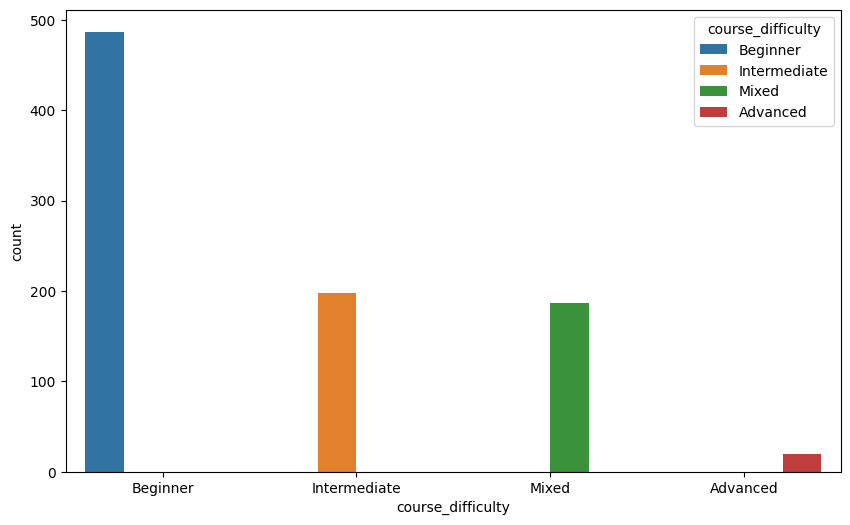

In [17]:
fig_dims = (10,6)
fig,ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='course_difficulty',data = df,ax=ax, hue="course_difficulty");

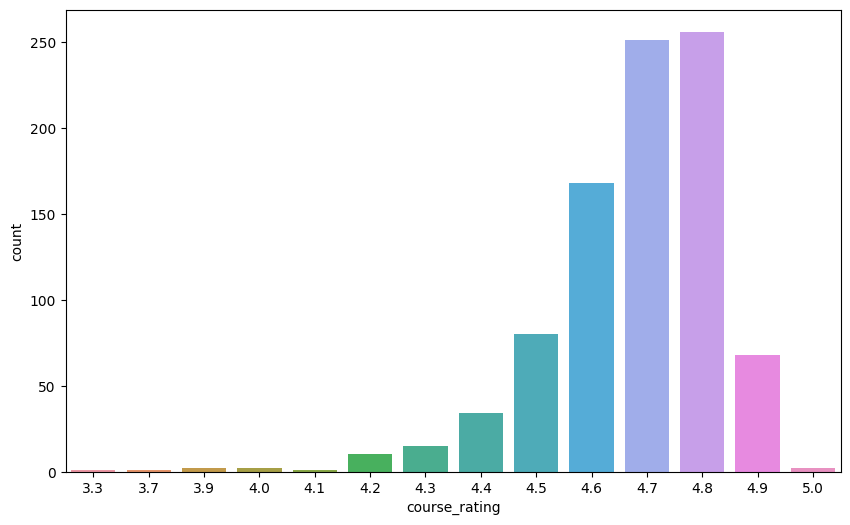

In [18]:
fig_dims = (10,6)
fig,ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='course_rating',data = df,ax=ax);

In [21]:
df.course_students_enrolled.apply(lambda count : count[-1]).value_counts()

k    887
m      4
Name: course_students_enrolled, dtype: int64

In [22]:
df = df[df['course_students_enrolled'].str.endswith('k')]
df['course_students_enrolled'] = df['course_students_enrolled'].str.rstrip('k').astype(float) * 1000


<ipython-input-22-17d682956dfb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['course_students_enrolled'] = df['course_students_enrolled'].str.rstrip('k').astype(float) * 1000


In [23]:
df

,course_title,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,SPECIALIZATION,4.7,Beginner,5300.0
1,A Crash Course in Causality: Inferring Causal...,COURSE,4.7,Intermediate,17000.0
2,A Crash Course in Data Science,COURSE,4.5,Mixed,130000.0
3,A Law Student's Toolkit,COURSE,4.7,Mixed,91000.0
4,A Life of Happiness and Fulfillment,COURSE,4.8,Mixed,320000.0
...,...,...,...,...,...
886,Программирование на Python,SPECIALIZATION,4.5,Intermediate,52000.0
887,Психолингвистика (Psycholinguistics),COURSE,4.8,Mixed,21000.0
888,Разработка интерфейсов: вёрстка и JavaScript,SPECIALIZATION,4.5,Intermediate,30000.0
889,Русский как иностранный,SPECIALIZATION,4.6,Intermediate,9800.0


3.Feature Engineering
TF-IDF Vectorization for course titles

In [27]:
minmax_scaler = MinMaxScaler()
scaled_ratings = minmax_scaler.fit_transform(df[['course_rating','course_students_enrolled']])

In [30]:
df['course_rating'] = scaled_ratings[:,0]
df['course_students_enrolled'] = scaled_ratings[:,1]
df['overall_rating'] = df[['course_rating','course_students_enrolled']].apply(lambda row : harmonic_mean(row), axis=1)

<ipython-input-30-819f6738c823>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['course_rating'] = scaled_ratings[:,0]
<ipython-input-30-819f6738c823>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['course_students_enrolled'] = scaled_ratings[:,1]
<ipython-input-30-819f6738c823>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [31]:
df

,course_title,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,overall_rating
0,(ISC)² Systems Security Certified Practitioner...,SPECIALIZATION,0.823529,Beginner,0.004587,0.009122
1,A Crash Course in Causality: Inferring Causal...,COURSE,0.823529,Intermediate,0.018709,0.036586
2,A Crash Course in Data Science,COURSE,0.705882,Mixed,0.155100,0.254319
3,A Law Student's Toolkit,COURSE,0.823529,Mixed,0.108027,0.190999
4,A Life of Happiness and Fulfillment,COURSE,0.882353,Mixed,0.384430,0.535534
...,...,...,...,...,...,...
886,Программирование на Python,SPECIALIZATION,0.705882,Intermediate,0.060954,0.112217
887,Психолингвистика (Psycholinguistics),COURSE,0.882353,Mixed,0.023537,0.045850
888,Разработка интерфейсов: вёрстка и JavaScript,SPECIALIZATION,0.705882,Intermediate,0.034400,0.065602
889,Русский как иностранный,SPECIALIZATION,0.764706,Intermediate,0.010018,0.019777


In [32]:
df = df[df.course_title.apply(lambda title : detect(title) == 'en')]

In [58]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(df.course_title)
vectors_train = vectorizer.fit_transform(train_df['course_title'])
vectors_test = vectorizer.transform(test_df['course_title'])


4.Machine Learning Model
Recommendation function

In [64]:
# Recommendation function
def recommend_by_course_title(title, recomm_count=10, df=train_df, vectors=vectors_train):
    title_vector = vectorizer.transform([title])
    cosine_sim = np.squeeze(cosine_similarity(vectors, title_vector))
    idx = np.argsort(cosine_sim)[-recomm_count:][::-1]
    sdf = df.iloc[idx].sort_values(by='overall_rating', ascending=False)
    return sdf['course_title'].tolist()

In [65]:
recommend_by_course_title('A Crash Course in Data Science')

['Applied Data Science with Python',
 'Introduction to Data Science',
 'What is Data Science?',
 'Applied Data Science',
 'Python for Data Science and AI',
 'SQL for Data Science',
 'Data Science Methodology',
 'Crash Course on Python',
 'A Crash Course in Causality:  Inferring Causal Effects from Observational Data',
 'Mathematics for Data Science']

5.Model Evaluation
Split the dataset into training and testing sets

In [44]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [69]:
# Evaluate the model using MSE

from sklearn.metrics import mean_squared_error

def calculate_mse(model_function, test_data):
    mse_list = []

    for _, row in test_data.iterrows():
        title = row['course_title']
        actual_rating = row['overall_rating']
        recommendations = model_function(title, df=train_df, vectors=vectors_train)

        # If the recommended course is in the training set, use its rating; otherwise, assume a neutral rating
        predicted_rating = train_df[train_df['course_title'].isin(recommendations)]['overall_rating'].mean() or 0.0

        mse_list.append((actual_rating - predicted_rating)**2)

    mse = np.mean(mse_list)
    return mse

# Example usage
mse = calculate_mse(recommend_by_course_title, test_df)
print(f'Mean Squared Error (MSE): {mse:.2f}')


Mean Squared Error (MSE): 0.02


6.Model Tuning
Experiment with hyperparameter tuning

In [73]:
# Recommendation function with hyperparameter tuning
def recommend_by_course_title(title, recomm_count=10, cosine_similarity_threshold=0.5, df=train_df, vectors=vectors_train):
    title_vector = vectorizer.transform([title])
    cosine_sim = np.squeeze(cosine_similarity(vectors, title_vector))
    idx = np.argsort(cosine_sim)[-recomm_count:][::-1]

    # Apply cosine similarity threshold
    idx = [i for i in idx if cosine_sim[i] >= cosine_similarity_threshold]

    sdf = df.iloc[idx].sort_values(by='overall_rating', ascending=False)
    return sdf['course_title'].tolist()

# Model evaluation function with hyperparameter tuning
def evaluate_recommendation_model(model_function, test_data, threshold=4.0, recomm_count=10, cosine_similarity_threshold=0.5):
    actual_recommendations = []
    predicted_recommendations = []

    for _, row in test_data.iterrows():
        title = row['course_title']
        actual_recommendations.append(row['overall_rating'])
        recommendations = model_function(title, df=train_df, vectors=vectors_train, recomm_count=recomm_count, cosine_similarity_threshold=cosine_similarity_threshold)

        # If the recommended course is in the training set, use its rating; otherwise, assume a neutral rating
        predicted_rating = train_df[train_df['course_title'].isin(recommendations)]['overall_rating'].mean() or 0.0

        predicted_recommendations.append((title, recommendations))

    # Calculate MSE
    mse_list = [(actual_rating - predicted_rating)**2 for actual_rating, (_, predictions) in zip(test_data['overall_rating'], predicted_recommendations)]
    mse = np.mean(mse_list)

    return mse

# Example usage for hyperparameter tuning
best_mse = float('inf')
best_recomm_count = None
best_cosine_similarity_threshold = None

for recomm_count in range(5, 16):
    for threshold in np.arange(0.2, 1.0, 0.1):
        mse = evaluate_recommendation_model(recommend_by_course_title, test_df, recomm_count=recomm_count, cosine_similarity_threshold=threshold)

        if mse < best_mse:
            best_mse = mse
            best_recomm_count = recomm_count
            best_cosine_similarity_threshold = threshold

print(f'Best Mean Squared Error (MSE): {best_mse:.4f} | Best recomm_count: {best_recomm_count} | Best cosine_similarity_threshold: {best_cosine_similarity_threshold:.2f}')


Best Mean Squared Error (MSE): 0.0283 | Best recomm_count: 13 | Best cosine_similarity_threshold: 0.20
